In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Path to your dataset folder in Kaggle
dataset_path = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"  

# Get any one image file from the folder
image_files = [f for f in os.listdir(dataset_path) if f.endswith('.png') or f.endswith('.jpg')]

print("Total images found:", len(image_files))

# Pick the first image
sample_image = image_files[0]
image_path = os.path.join(dataset_path, sample_image)

# Read the image
img = cv2.imread(image_path)

# Convert BGR to RGB for correct display
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.title("Sample Chest X-ray Image")
plt.axis("off")
plt.show()


In [ ]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)


In [ ]:
import os

train_path = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"

print(os.listdir(train_path)[:10])  # show first 10 files


In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt

# Path to train folder
dataset_path = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"

# List all .dicom files
dicom_files = [f for f in os.listdir(dataset_path) if f.endswith('.dicom')]

print("Total DICOM images found:", len(dicom_files))

# Pick the first file
sample_file = dicom_files[14000]
sample_path = os.path.join(dataset_path, sample_file)

print("Showing image:", sample_file)

# Load DICOM file
dicom_img = pydicom.dcmread(sample_path)

# Convert pixel data to array
img = dicom_img.pixel_array

# Show the image
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.title("Sample Chest X-ray (DICOM)")
plt.axis("off")
plt.show()


In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt

# Step 1: Automatically find the folder containing DICOMs
dicom_files = []
for root, _, files in os.walk('/kaggle/input'):
    for f in files:
        if f.lower().endswith(('.dcm', '.dicom')):
            dicom_files.append(os.path.join(root, f))

# Step 2: Check if any files found
if len(dicom_files) == 0:
    print("No DICOM files found in /kaggle/input. Check your dataset structure.")
else:
    print(f" Found {len(dicom_files)} DICOM files.")
    print("Example file path:", dicom_files[0])

    # Step 3: Visualize first two DICOMs with metadata
    for i in range(min(2, len(dicom_files))):
        dicom_path = dicom_files[i]
        dicom_data = pydicom.dcmread(dicom_path)
        image = dicom_data.pixel_array

        # Normalize for better visualization
        image = (image - image.min()) / (image.max() - image.min())
        # Display image
        plt.figure(figsize=(8,8))
        plt.imshow(image, cmap='gray')
        plt.title(f"VinDr-CXR Sample {i+1}\n{dicom_data.get('ViewPosition', 'Unknown View')}")
        plt.axis('off')
        plt.show()

In [ ]:
import os

base_path = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection"

for root, dirs, files in os.walk(base_path):
    print(root)
    for f in files[:5]:  # show first 5 files in each folder
        print("   ", f)
    print("-----")


In [ ]:
import pydicom
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
# Path to any DICOM file
dicom_path = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/4d390e07733ba06e5ff07412f09c0a92.dicom"

import pydicom
import matplotlib.pyplot as plt

dicom = pydicom.dcmread(dicom_path)
image = dicom.pixel_array

plt.imshow(image, cmap='gray')
plt.title("Loaded DICOM Image")
plt.axis('off')
plt.show()

In [ ]:
# Convert 1-channel grayscale to 3-channel RGB
import cv2
import numpy as np

image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
plt.imshow(image_rgb)
plt.title("RGB Image")
plt.axis("off")



In [ ]:
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt

dicom_path = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/4d390e07733ba06e5ff07412f09c0a92.dicom"

dicom = pydicom.dcmread(dicom_path)
image = dicom.pixel_array.astype(np.float32)

# Normalize correctly for THIS dataset
image = (image - np.min(image)) / (np.max(image) - np.min(image))

# Convert to RGB (3 channels)
rgb = np.stack([image]*3, axis=-1)

plt.imshow(rgb, cmap="gray")
plt.title("Correct RGB Image")
plt.axis("off")
plt.show()


In [3]:
import os
import pydicom
import numpy as np
import cv2
import torch
import torchvision.transforms as T
from tqdm import tqdm
import gc


In [4]:
# Convert DICOM → RGB (with windowing)
def dicom_to_rgb(dicom):
    img = dicom.pixel_array.astype(np.float32)

    # Windowing
    wc = dicom.get("WindowCenter", 40)
    ww = dicom.get("WindowWidth", 400)

    if isinstance(wc, pydicom.multival.MultiValue):
        wc = wc[0]
    if isinstance(ww, pydicom.multival.MultiValue):
        ww = ww[0]

    min_val = wc - ww//2
    max_val = wc + ww//2

    img = np.clip(img, min_val, max_val)
    img = (img - min_val) / (max_val - min_val + 1e-6)
    
    # Convert 1 channel → 3 channel RGB
    img_rgb = np.stack([img, img, img], axis=-1)
    img_rgb = (img_rgb * 255).astype(np.uint8)

    return img_rgb


# Resize + Tensor
transform = T.Compose([
    T.ToTensor(),                  # HWC → CHW
    T.Resize((128,128)),           # resize
])


In [5]:
def preprocess_files(file_list, folder_path):
    tensors = []

    for file in tqdm(file_list, desc="Processing batch"):
        dicom_path = os.path.join(folder_path, file)
        dicom = pydicom.dcmread(dicom_path)

        rgb = dicom_to_rgb(dicom)
        tensor_img = transform(rgb)
        tensors.append(tensor_img)

    return tensors


In [6]:
train_folder = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train"
all_files = sorted([f for f in os.listdir(train_folder) if f.endswith(".dicom")])

total = len(all_files)
batch_size = total // 5

batches = [
    all_files[i*batch_size : (i+1)*batch_size] for i in range(5)
]

# Add remaining files to the last batch
batches[-1].extend(all_files[5*batch_size:])


In [9]:
import os
import torch
import gc

output_dir = "/kaggle/working/preprocessed_batches"
os.makedirs(output_dir, exist_ok=True)

for i, batch_files in enumerate(batches):
    print(f"\n🔥 Processing Batch {i+1}/5 ({len(batch_files)} images)")

    save_path = os.path.join(output_dir, f"batch_{i+1}.pt")

    # -------------------------
    # RESUME LOGIC
    # -------------------------
    if os.path.exists(save_path):
        print(f"✔ Batch {i+1} already completed — skipping.")
        continue

    temp_path = save_path + ".partial"

    # If partial file exists → load progress
    if os.path.exists(temp_path):
        print("🔁 Resuming from partial progress...")
        batch_tensors = torch.load(temp_path)
        start_idx = len(batch_tensors)
    else:
        batch_tensors = []
        start_idx = 0

    # -------------------------
    # Process remaining images
    # -------------------------
    for idx in range(start_idx, len(batch_files)):
        filepath = os.path.join(train_folder, batch_files[idx])

        try:
            img_tensor = process_single_image(filepath)
            batch_tensors.append(img_tensor)
        except Exception as e:
            print(f"⚠️ Error processing {batch_files[idx]}: {e}")
            continue

        # Save partial every 50 images
        if idx % 50 == 0:
            torch.save(batch_tensors, temp_path)
            print(f"💾 Saved partial progress at index {idx}")

    # -------------------------
    # Save final batch
    # -------------------------
    torch.save(batch_tensors, save_path)
    print(f"✔ Saved Batch {i+1} --> {save_path}")

    # Remove partial file
    if os.path.exists(temp_path):
        os.remove(temp_path)

    del batch_tensors
    gc.collect()



🔥 Processing Batch 1/5 (3000 images)
✔ Batch 1 already completed — skipping.

🔥 Processing Batch 2/5 (3000 images)
✔ Batch 2 already completed — skipping.

🔥 Processing Batch 3/5 (3000 images)
✔ Batch 3 already completed — skipping.

🔥 Processing Batch 4/5 (3000 images)
✔ Batch 4 already completed — skipping.

🔥 Processing Batch 5/5 (3000 images)
✔ Batch 5 already completed — skipping.


In [11]:
import os

output_dir = "/kaggle/working/preprocessed_batches"
files = os.listdir(output_dir)
files


['batch_5.pt', 'batch_1.pt', 'batch_4.pt', 'batch_3.pt', 'batch_2.pt']

In [12]:
for f in files:
    size = os.path.getsize(os.path.join(output_dir, f))
    print(f"{f} --> {size/1024/1024:.2f} MB")


batch_5.pt --> 563.28 MB
batch_1.pt --> 563.28 MB
batch_4.pt --> 563.28 MB
batch_3.pt --> 563.28 MB
batch_2.pt --> 563.28 MB


In [14]:
import torch

batch = torch.load("/kaggle/working/preprocessed_batches/batch_1.pt")
print(type(batch))
print(len(batch))



<class 'list'>
3000


In [15]:
first_img = batch[0]
print(first_img.shape)


torch.Size([3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


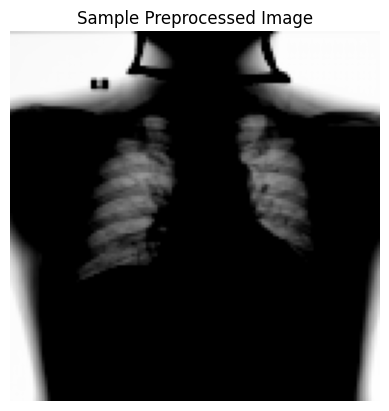

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Convert CHW → HWC for plotting
img = first_img.permute(1, 2, 0).numpy()

plt.imshow(img)
plt.title("Sample Preprocessed Image")
plt.axis("off")
plt.show()


In [17]:
import torch

batch = torch.load("/kaggle/working/preprocessed_batches/batch_1.pt")

bad = []

for i, t in enumerate(batch):
    if t.shape[0] != 3:
        bad.append((i, t.shape))

print("Total images:", len(batch))
print("Non-RGB images found:", len(bad))
print("Examples:", bad[:5])


Total images: 3000
Non-RGB images found: 0
Examples: []


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


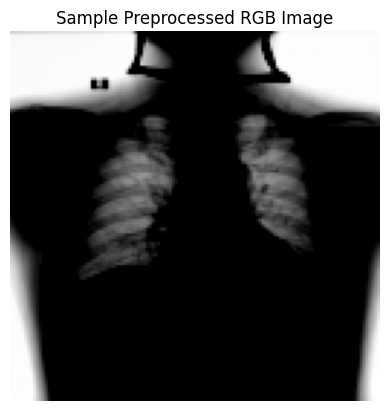

In [18]:
import matplotlib.pyplot as plt
import torch

batch = torch.load("/kaggle/working/preprocessed_batches/batch_1.pt")
img = batch[0].permute(1, 2, 0)  # CHW → HWC for display

plt.imshow(img)
plt.title("Sample Preprocessed RGB Image")
plt.axis("off")
plt.show()
